In [2]:
import numpy as np
from scipy.sparse import csc_matrix,coo_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from numpy import linalg as LA
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import umap
import kmapper as km
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from community import best_partition # this is not part of networkx
from matplotlib.colors import ListedColormap

def convertNansToZeros(ma):
    nan_elements = np.flatnonzero(np.isnan(ma.data))
    if len(nan_elements) > 0:
        ma.data[nan_elements] = 0
    return ma


def convertInfsToZeros(ma):
    inf_elements = np.flatnonzero(np.isinf(ma.data))
    if len(inf_elements) > 0:
        ma.data[inf_elements] = 0
    return ma

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.1, n_components=6, n_epochs=None,
   n_neighbors=40, negative_sample_rate=5, random_state=1571,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (17335, 501)

..Projecting data using: 
	UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='correlation',
   metric_kwds=None, min_dist=0.1, n_components=6, n_epochs=None,
   n_neighbors=40, negative_sample_rate=5, random_state=1571,
   repulsion_strength=1.0, set_

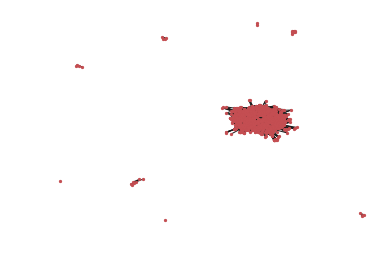

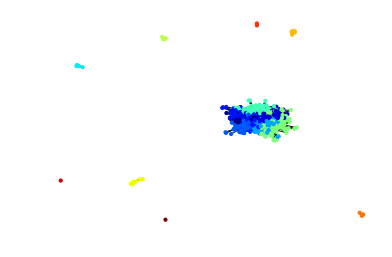

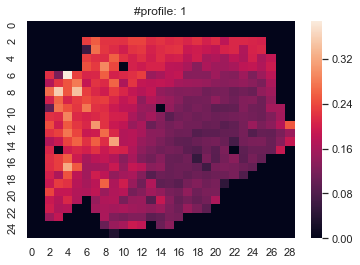

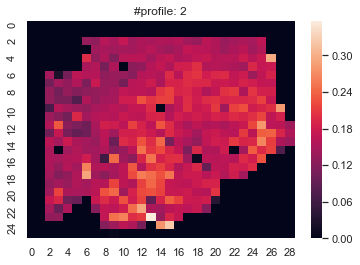

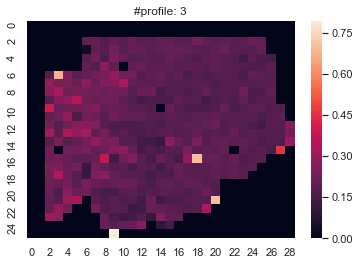

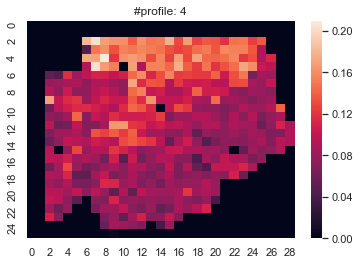

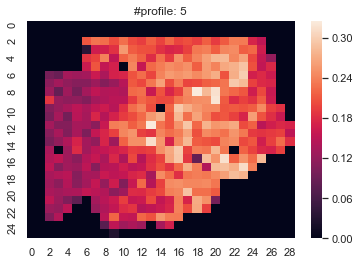

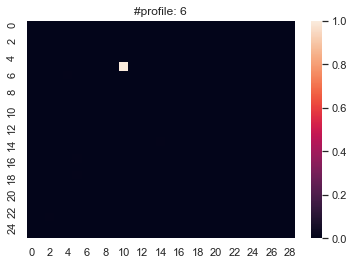

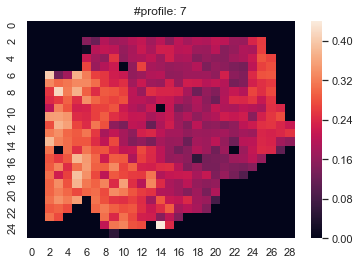

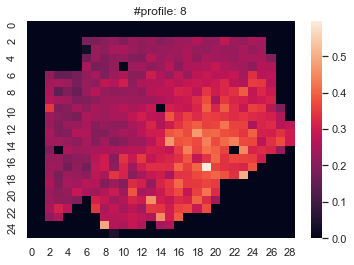

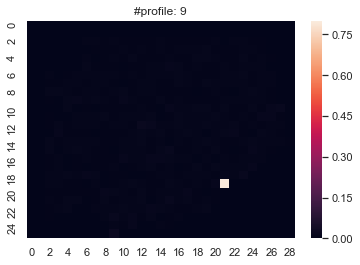

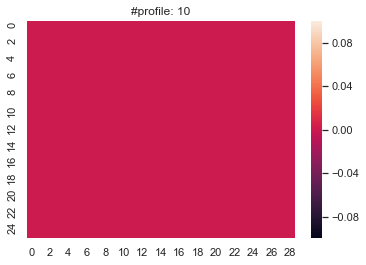

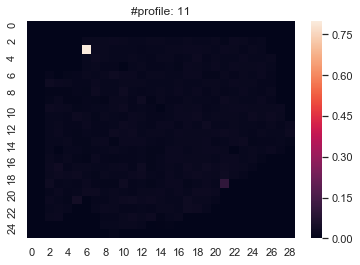

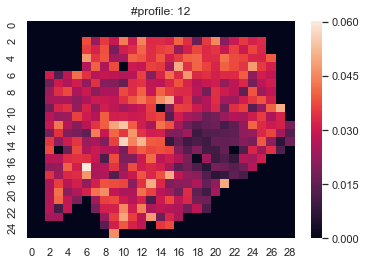

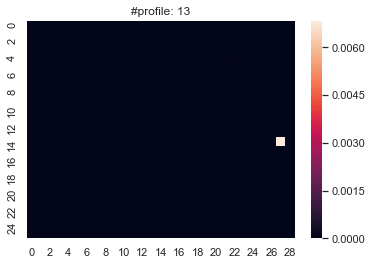

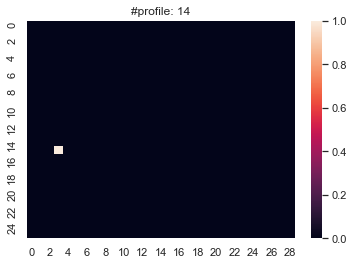

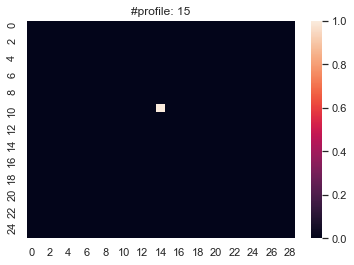

In [17]:
# %matplotlib
datadir = '/home/garner1/Work/dataset/SSF/prostate-twelve/'
section = 'P3.3'

filename = datadir+section+'.tsv'

df = pd.read_csv(filename, sep='\t', header=0, index_col=0) # read the gene X position count-matrix
dfnorm = df.div(df.sum(axis=0),axis=1) #normalize to probabilities the transcriptome at each position

data = dfnorm.values

k = 10
u, s, vt = svds(csc_matrix(data).asfptype(), k=k,which='LM')
data = np.dot(u,np.dot(np.diag(s),vt))

'''Initialize'''
mapper = km.KeplerMapper(verbose=1)

'''Fit to and transform the data'''
n_components = 6 # from 5 on there are problems in linkning the nodes
random_state = 1571
projected_data = mapper.fit_transform(data, projection=umap.UMAP(n_neighbors=40,
                                                                 min_dist=0.1,
                                                                 n_components=n_components,
                                                                 metric='correlation',
                                                                 random_state=random_state))
'''Create dictionary called 'graph' with nodes, edges and meta-information'''
nr_cubes = 10
graph = mapper.map(projected_data, data,
                   clusterer=DBSCAN(eps=0.5, min_samples=1),
                   coverer=km.Cover(nr_cubes=nr_cubes, overlap_perc=0.5))

'''Visualize the mapper graph'''
mapper.visualize(graph, path_html=section+".UMAP.cubes"+str(nr_cubes)+".components"+str(n_components)+".rndstate"+str(random_state)+"_mapper_output.html",title=filename)

'''Build the network'''
net = km.to_networkx(graph)
print nx.info(net)

'''Create network layout for visualizations'''
spring_pos = nx.spring_layout(net)
plt.figure()
plt.axis("off")
nx.draw_networkx(net, pos = spring_pos, with_labels = False, node_size = 5)

'''Partition the network'''
parts = best_partition(net)
values = [parts.get(node) for node in net.nodes()]
plt.figure()
plt.axis("off")
nx.draw_networkx(net, pos = spring_pos, cmap = plt.get_cmap("jet"), 
                 node_color = values, node_size = 10, with_labels = False)

'''Get all the nodes in a module'''
groups = []
for value in set(parts.values()):
    value_keys = [node for node in parts.keys() if value == parts[node]]
    groups.append(value_keys) 

'''Get the entire space-profile'''
summa = dfnorm.sum(axis=0) # sum over all probabilities (to get 1!!!)
spatialCoord = [w.split('x') for w in list(summa.index.values)]
spatialCoord = [map(int,pairs) for pairs in spatialCoord]
i = [l[0] for l in spatialCoord]
j = [l[1] for l in spatialCoord]
maxi = max(i)+1
maxj = max(j)+1
data = summa.values
mat_global = coo_matrix((data, (i, j)), [maxi, maxj]).todense()

'''Plot the spatial projection of the modules'''
ind = 0 
for group in range(len(groups)):

    spots = [graph['nodes'][node] for node in groups[group]]
    l = list(set([item for sublist in spots for item in sublist]))
    
    newdf = dfnorm.iloc[l,:]
    summa = newdf.sum(axis=0)

    spatialCoord = [w.split('x') for w in list(summa.index.values)]
    spatialCoord = [map(int,pairs) for pairs in spatialCoord]

    i = [s[0] for s in spatialCoord]
    j = [s[1] for s in spatialCoord]

    if len(i) > 0:
        ind += 1
        plt.figure()
        mat = coo_matrix((summa.values, (i, j)), [maxi, maxj]).todense()
#         mat = 2*mat_global - mat
#         cmap = sns.color_palette("husl", 3)
        sns.heatmap(mat)
        plt.title("#profile: "+str(ind))

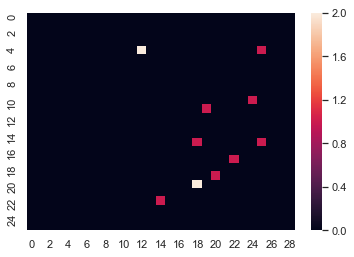

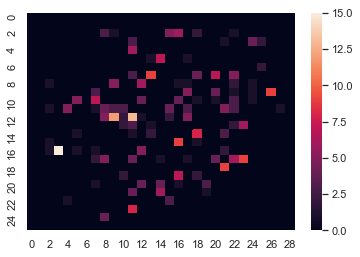

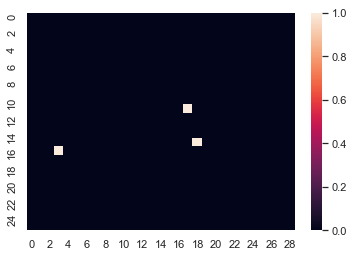

In [18]:
'''Plot spatial distribution of RC for a given gene'''
for gene in ["SPON1","TFF3","SPINK1"]:
    getGene = df[df.index.str.contains(gene)==True].transpose()

    spatialCoord = [w.split('x') for w in list(getGene.index.values)]
    spatialCoord = [map(int,pairs) for pairs in spatialCoord]

    i = [s[0] for s in spatialCoord]
    j = [s[1] for s in spatialCoord]

    plt.figure()
    mat = coo_matrix((getGene.values.ravel(), (i, j)), [maxi, maxj]).todense()
    sns.heatmap(mat, annot=False)